# Analysis of Deaths Due to Heart Disease in the US - 2005
---

In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import linregress 
import requests
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#Definitions
PEAK_AGE = 80

In [3]:
# Load the clean 2005 data CSV file into a Pandas DataFrame
clean_2005_DD_df = pd.read_csv("cleaned_data_csv_files/clean_output_2005_DD_df.csv", low_memory=False)

# Display sample data
print(clean_2005_DD_df.shape)
clean_2005_DD_df.head()

(1719615, 12)


,Death in United States 2005,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
0,0,45,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,Malignant melanoma of skin (C43),NaN
1,1,61,Years,Male,White,Divorced,Saturday,January,"Hospital, clinic or Medical Center",Natural,Emphysema (J43),NaN
2,2,79,Years,Female,White,Divorced,Sunday,January,Nursing home/long term care,Natural,Other cerebrovascular diseases and their seque...,NaN
3,3,50,Years,Male,White,"Never married, single",Wednesday,January,"Hospital, clinic or Medical Center",Natural,Diabetes mellitus (E10-E14),NaN
4,4,68,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,"Of trachea, bronchus and lung (C33-C34)",NaN


In [4]:
#Reset index to use patient data ID numbers from original CSV, not arbitrary index assignments
clean_2005_DD_df = clean_2005_DD_df.drop(columns=["Death in United States 2005"])
clean_2005_DD_df

,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
0,45,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,Malignant melanoma of skin (C43),NaN
1,61,Years,Male,White,Divorced,Saturday,January,"Hospital, clinic or Medical Center",Natural,Emphysema (J43),NaN
2,79,Years,Female,White,Divorced,Sunday,January,Nursing home/long term care,Natural,Other cerebrovascular diseases and their seque...,NaN
3,50,Years,Male,White,"Never married, single",Wednesday,January,"Hospital, clinic or Medical Center",Natural,Diabetes mellitus (E10-E14),NaN
4,68,Years,Female,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,"Of trachea, bronchus and lung (C33-C34)",NaN
...,...,...,...,...,...,...,...,...,...,...,...
1719610,47,Years,Male,White,Marital Status unknown,Saturday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719611,78,Years,Female,White,"Never married, single",Monday,September,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719612,32,Years,Female,White,Marital Status unknown,Tuesday,December,Decedent’s home,Natural,Diabetes mellitus (E10-E14),NaN
1719613,70,Years,Male,Black,Marital Status unknown,Sunday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN


In [5]:
#Create a new dataframe that only includes the data for individuals with a cause of death related to heart disease
selected_entries_heart = ["All other forms of chronic ischemic heart disease (I20,I25.1-I25.9)",
                    "Acute myocardial infarction (I21-I22)",
                    "Atherosclerotic cardiovascular disease, so described (I25.0)",
                    "Congestive heart failure (I50.0)"]

heart_disease_df = clean_2005_DD_df[clean_2005_DD_df["358_cause_recode_text"].isin(selected_entries_heart)]
heart_disease_df

,detail_age,detail_age_type_text,sex_text,race_text,marital_status_text,day_of_week_of_death_text,month_of_death_text,place_of_death_and_decedents_status_text,manner_of_death_text,358_cause_recode_text,130_infant_cause_recode_text
18,64,Years,Male,White,Divorced,Sunday,January,Other,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
58,63,Years,Male,White,Widowed,Friday,January,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
59,68,Years,Male,American Indian (includes Aleuts and Eskimos),"Never married, single",Saturday,January,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
65,81,Years,Female,White,Widowed,Saturday,January,Other,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
76,75,Years,Male,White,Married,Monday,January,"Hospital, clinic or Medical Center",Natural,All other forms of chronic ischemic heart dise...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1719608,65,Years,Female,Black,Marital Status unknown,Monday,December,"Hospital, Clinic or Medical Center",Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719610,47,Years,Male,White,Marital Status unknown,Saturday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719611,78,Years,Female,White,"Never married, single",Monday,September,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN
1719613,70,Years,Male,Black,Marital Status unknown,Sunday,December,Decedent’s home,Natural,"Atherosclerotic cardiovascular disease, so des...",NaN


In [6]:
#Determine the total number of deaths in 2005 due to heart disease
total_deaths_heart_disease = heart_disease_df.shape[0]
total_deaths_heart_disease

346185

### Total number of deaths due to heart disease in the US in 2005: 346185

In [7]:
#Import csv file with age and sex data for 2005
census_2005_data_df = pd.read_csv("source_files/census_pop_data_2000_2010.csv", low_memory=False)
census_2005_data_df.head()

,REGION,DIVISION,STATE,NAME,SEX,AGE,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010
0,0,0,0,United States,0,0,3805718,3855956,4012658,3951461,3975871,4014258,4004393,4041738,4147997,4132735,4003587,3944153,3952444
1,0,0,0,United States,0,1,3820647,3798691,3855407,4004674,3936139,3953063,3987032,3972124,4002215,4100756,4078797,3978070,3951024
2,0,0,0,United States,0,2,3790534,3800144,3800096,3856114,4002836,3933735,3952632,3988119,3973479,4004146,4103002,4096929,4087074
3,0,0,0,United States,0,3,3832855,3821118,3802710,3804336,3860727,4008220,3943215,3966022,4004011,3992320,4025675,4119040,4133855
4,0,0,0,United States,0,4,3926400,3902384,3827346,3812607,3816873,3876609,4030128,3970880,3998260,4041170,4033457,4063170,4076132


In [8]:
# Create dataframe showing age, sex, and population estimate for 2005
pop_data_2005_df = pd.DataFrame(census_2005_data_df, columns=["NAME", "AGE", "SEX", "POPESTIMATE2005"])
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
0,United States,0,0,4004393
1,United States,1,0,3987032
2,United States,2,0,3952632
3,United States,3,0,3943215
4,United States,4,0,4030128


In [9]:
#Restrict the data to only the entries representing all US, to avoid duplication when county entries lsited by state
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["NAME"] == "United States"]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
0,United States,0,0,4004393
1,United States,1,0,3987032
2,United States,2,0,3952632
3,United States,3,0,3943215
4,United States,4,0,4030128


In [10]:
#Clean population dataset to remove individuals that do not identify as male or female
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["SEX"] != 0]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
87,United States,0,1,2047711
88,United States,1,1,2036538
89,United States,2,1,2020295
90,United States,3,1,2012820
91,United States,4,1,2058231


In [52]:
#Clean population data to remove entries where the age in unknown (defined as 999)
pop_data_2005_df = pop_data_2005_df[pop_data_2005_df["AGE"] != 999]
pop_data_2005_df.head()

,NAME,AGE,SEX,POPESTIMATE2005
87,United States,0,Male,2047711
88,United States,1,Male,2036538
89,United States,2,Male,2020295
90,United States,3,Male,2012820
91,United States,4,Male,2058231


In [12]:
#Display the total population from the 2005 US Censue data for all age groups

# Calculate the total population for all ages in the DataFrame
total_population_all_ages = pop_data_2005_df['POPESTIMATE2005'].sum()

# Display the total population for all ages
print("Total Population for All Ages in 2005:", total_population_all_ages)

Total Population for All Ages in 2005: 295516599


### In 2005, the total US population was approximately 295.5 million people

In [13]:
#Determine the percentage of total population whose death was due to heart disease
overall_heart_disease_deaths = total_deaths_heart_disease / total_population_all_ages
overall_percentage_heart_disease_deaths = overall_heart_disease_deaths * 100

# Display the percentage of total population whose death was due to heart disease
print("{:.2f}%".format(overall_percentage_heart_disease_deaths))

0.12%


### In 2005, 0.12% of the US population had a cause of death related to heart disease

## 1. Is there a relationship between sex and dying of heart disease in the US?
---------------------------------------------------------------------------------

In [14]:
# Determine the number of heart disease deaths by sex
gender_count = heart_disease_df['sex_text']
male_count = len(heart_disease_df[heart_disease_df['sex_text'] == 'Male'])
female_count = len(heart_disease_df[heart_disease_df['sex_text'] == 'Female'])

print(male_count)
print(female_count)

180368
165817


### Total number of male deaths due to heart disease in the US in 2005: 180368
### Total number of female deaths due to heart disease in the US in 2005: 165817

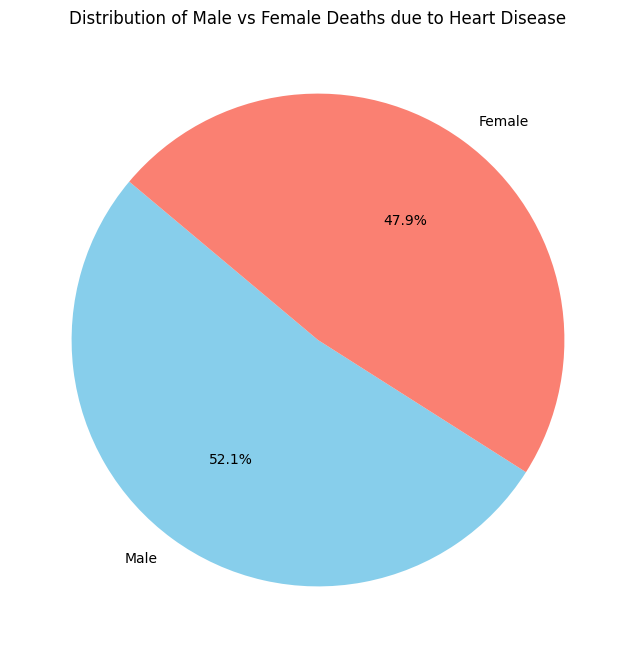

In [15]:
# Create a pie chart showing the percentage of male vs female patients whose caase of death was heart disease

# Filter out entries with age greater than 120 (Age Unknown populates as a number in the thousands)
filtered_df = heart_disease_df[heart_disease_df['detail_age'] <= 120]

# Define age groups for aggregation
# Create age bins of width 10
age_bins = np.arange(0, 121, 10)  

# Create a new column 'age_group' based on the age bins
filtered_df['age_group'] = pd.cut(filtered_df['detail_age'], bins=age_bins, labels=age_bins[:-1])

# Calculate the count of male and female
gender_counts = heart_disease_df['sex_text'].value_counts()

# Define colors
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Male vs Female Deaths due to Heart Disease')
plt.show()

In [16]:
#Evalute the difference in males vs females dying of heart disease. Set up Chi-Squared analysis.

#Define groups to obtain data for males and females dying of heart disease
contingency_table = pd.crosstab(index=heart_disease_df["sex_text"], columns="count")
contingency_table

#Define observed data (from heart_disease_df)
observed = pd.Series([165817,180368], index=["Female", "Male"])

#Create a new dataframe
chi_sq_heart_disease = pd.DataFrame([observed]).T

#Add column with expected values (should be equal: (165817+180368)/2 = 173092.5
chi_sq_heart_disease[1] = 173092.5

#Rename columns
chi_sq_heart_disease.columns = ["observed", "expected"]

# The degree of freedom is 2-1 = 1
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q = 0.95, df = 2)

print(f"Critical value: {(critical_value)}")

Critical value: 5.991464547107979


In [17]:
#Evalute the difference in males vs females dying of heart disease. Run the Chi-Squared analysis.

stats.chisquare(chi_sq_heart_disease['observed'], chi_sq_heart_disease['expected'])

Power_divergenceResult(statistic=611.6140242933692, pvalue=4.985356745005745e-135)

### There is a statisically significant difference between male and female deaths in the US due to heart disease. p<<<0.05
### While the signficance of the difference may not be immediately apparent in the pie plot, male = 52.1% vs female = 47.9%, the Chi-Squared anlaysis show this difference is substantial, with males much more likely to die of heart disease than their female counterparts.  

In [18]:
# Create a mapping dictionary for sex
sex_mapping = {1: 'Male', 2: 'Female'}

# Map the values in the 'SEX' column using the mapping dictionary
pop_data_2005_df['SEX'] = pop_data_2005_df['SEX'].map(sex_mapping)

# Display the updated DataFrame
print(pop_data_2005_df)

              NAME  AGE     SEX  POPESTIMATE2005
87   United States    0    Male          2047711
88   United States    1    Male          2036538
89   United States    2    Male          2020295
90   United States    3    Male          2012820
91   United States    4    Male          2058231
..             ...  ...     ...              ...
255  United States   81  Female           742630
256  United States   82  Female           683339
257  United States   83  Female           648391
258  United States   84  Female           595097
259  United States   85  Female          3249455

[172 rows x 4 columns]


In [19]:
# Group by 'SEX' column and sum the 'POPESTIMATE2005' column
population_by_sex = pop_data_2005_df.groupby('SEX')['POPESTIMATE2005'].sum()

# Display the total population by sex
print(population_by_sex)

SEX
Female    150319521
Male      145197078
Name: POPESTIMATE2005, dtype: int64


In [21]:
# Calculate the total population
total_population = population_by_sex.sum()

# Calculate the percentage of the total population for each sex
population_percentage_by_sex = (population_by_sex / total_population) * 100

# Display the percentage of the total population for males and females
population_percentage_by_sex

SEX
Female    50.866693
Male      49.133307
Name: POPESTIMATE2005, dtype: float64

In [37]:
#Determine if percentages of male vs female dying from heart disease align with total population percentages. 
#Calculate percent difference between the affected and population percentages

# Total population of males vs affected males
male_pcnt_diff = ((abs(49.1 - male_count))/male_count) * 100

# Total population of females vs affected females
female_pcnt_diff = ((abs(50.9 - female_count))/female_count) * 100

print(f"The percent difference between the total male population and the affected male population is: {male_pcnt_diff:.2f}%")
print(f"The percent difference between the total female population and the affected female population is: {female_pcnt_diff:.2f}%")

The percent difference between the total male population and the affected male population is: 99.97%
The percent difference between the total female population and the affected female population is: 99.97%


### In both males and females, the difference between the representation in the total population and the population affected by heart disease is substantially different. In the general population, females make up a slightly higher percetange of individuals, yet males make up a higher percentage of individuals whose death is attributed to heart disease. *Additional evaluation is required to determine statistical significance.* 

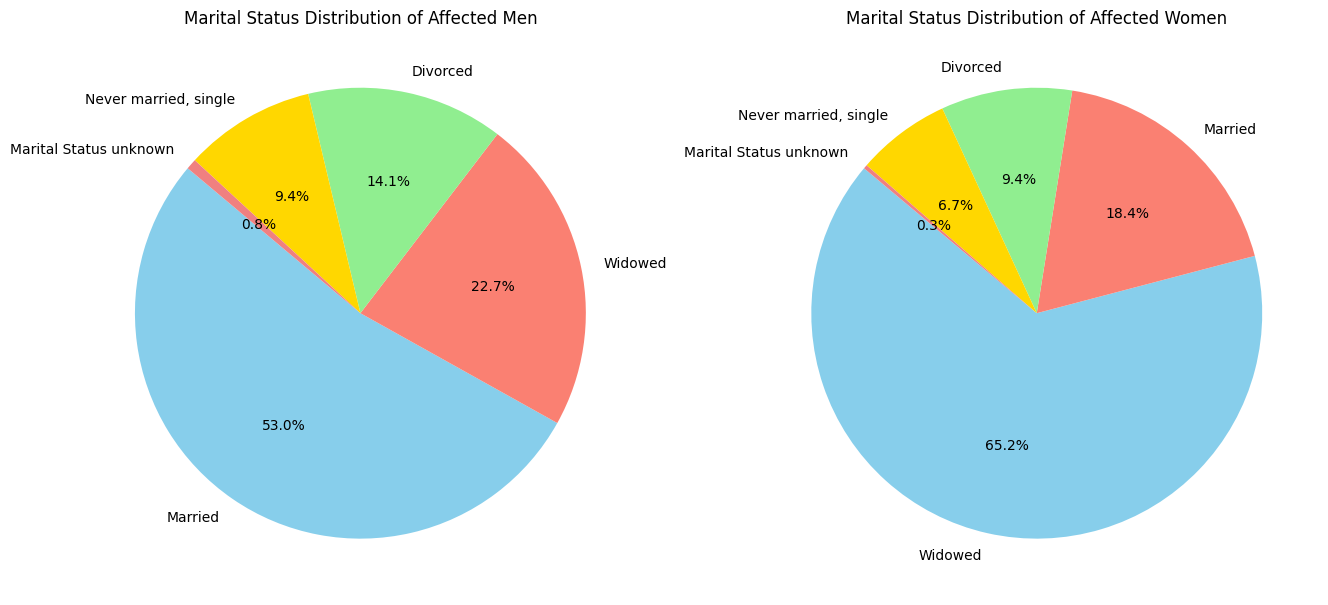

In [38]:
#Is there a relationship between the marital status of individuals and dying of heart disease?

# Filter for sex in the dataset
men_df = filtered_df[filtered_df['sex_text'] == 'Male']
women_df = filtered_df[filtered_df['sex_text'] == 'Female']

# Calculate the count of marital statuses for each sex
men_marital_counts = men_df['marital_status_text'].value_counts()
women_marital_counts = women_df['marital_status_text'].value_counts()

# Create pie charts, per sex, with different colors for each marital status
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral', 'lightskyblue', 'lightpink']

# Create subplots for male and female pie charts
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot pie chart for men
axs[0].pie(men_marital_counts, labels=men_marital_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
axs[0].set_title('Marital Status Distribution of Affected Men')

# Plot pie chart for women
axs[1].pie(women_marital_counts, labels=women_marital_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
axs[1].set_title('Marital Status Distribution of Affected Women')

plt.show()

In [ ]:
#Describe any findings about martial status (compare vs general population)
#Still pending to-do

In [60]:
# Describe the frequency of heart disease by sex

# Mean
average_male_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Male', 'detail_age'].mean()
average_female_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Female', 'detail_age'].mean()

# Median
median_male_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Male', 'detail_age'].median()
median_female_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Female', 'detail_age'].median()

# Mode
mode_male_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Male', 'detail_age'].mode().iloc[0]
mode_female_count = heart_disease_df.loc[heart_disease_df['sex_text'] == 'Female', 'detail_age'].mode().iloc[0]

# Calculate the statistical differences between males and females
mean_difference = average_male_count - average_female_count
median_difference = median_male_count - median_female_count
mode_difference = mode_male_count - mode_female_count

print(f"Average count for males: {average_male_count}")
print(f"Median count for males: {median_male_count}")
print(f"Mode count for males: {mode_male_count}")
print (f"-----------------------------------------------")
print(f"Average count for females: {average_female_count}")
print(f"Median count for females: {median_female_count}")
print(f"Mode count for females: {mode_female_count}")
print (f"-----------------------------------------------")
print(f"Difference in Mean Age: {mean_difference:.2f}")
print(f"Difference in Median Age: {median_difference:.2f}")
print(f"Difference in Mode Age: {mode_difference:.2f}")

Average count for males: 73.60675951388274
Median count for males: 76.0
Mode count for males: 84
-----------------------------------------------
Average count for females: 81.8883226689664
Median count for females: 84.0
Mode count for females: 87
-----------------------------------------------
Difference in Mean Age: -8.28
Difference in Median Age: -8.00
Difference in Mode Age: -3.00


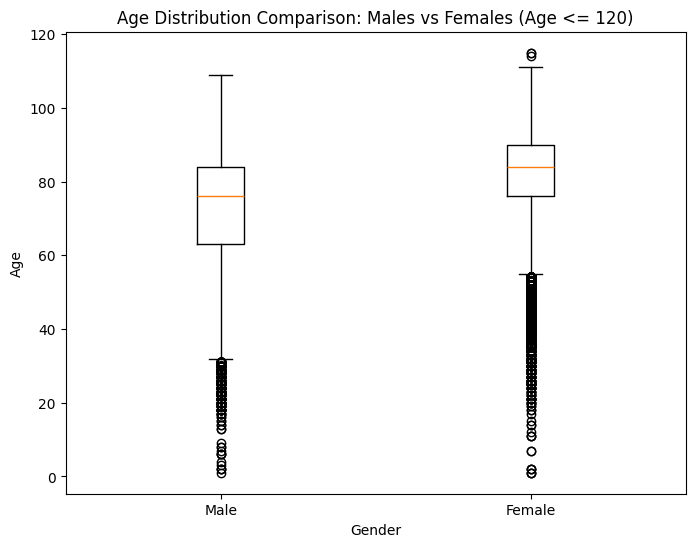

In [58]:
#Create a box and whisker plot to demonstrate the affected
# Filter the heart disease dataframe for males and females, excluding age values above 120
male_data = heart_disease_df.loc[(heart_disease_df['sex_text'] == 'Male') & (heart_disease_df['detail_age'] <= 120), 'detail_age']
female_data = heart_disease_df.loc[(heart_disease_df['sex_text'] == 'Female') & (heart_disease_df['detail_age'] <= 120), 'detail_age']

# Create a box and whisker plot for males vs females with age values below 120
plt.figure(figsize=(8, 6))
plt.boxplot([male_data, female_data], labels=['Male', 'Female'])
plt.title('Age Distribution Comparison: Males vs Females (Age <= 120)')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.show()

### When evaluating the mean, median or mode between males and females...in each case, females outlive their males conterparts by 3 to 8 years.    
### *Additional evaluation is required to determine if this holds true for each subcategory of heart diease leading to death.*

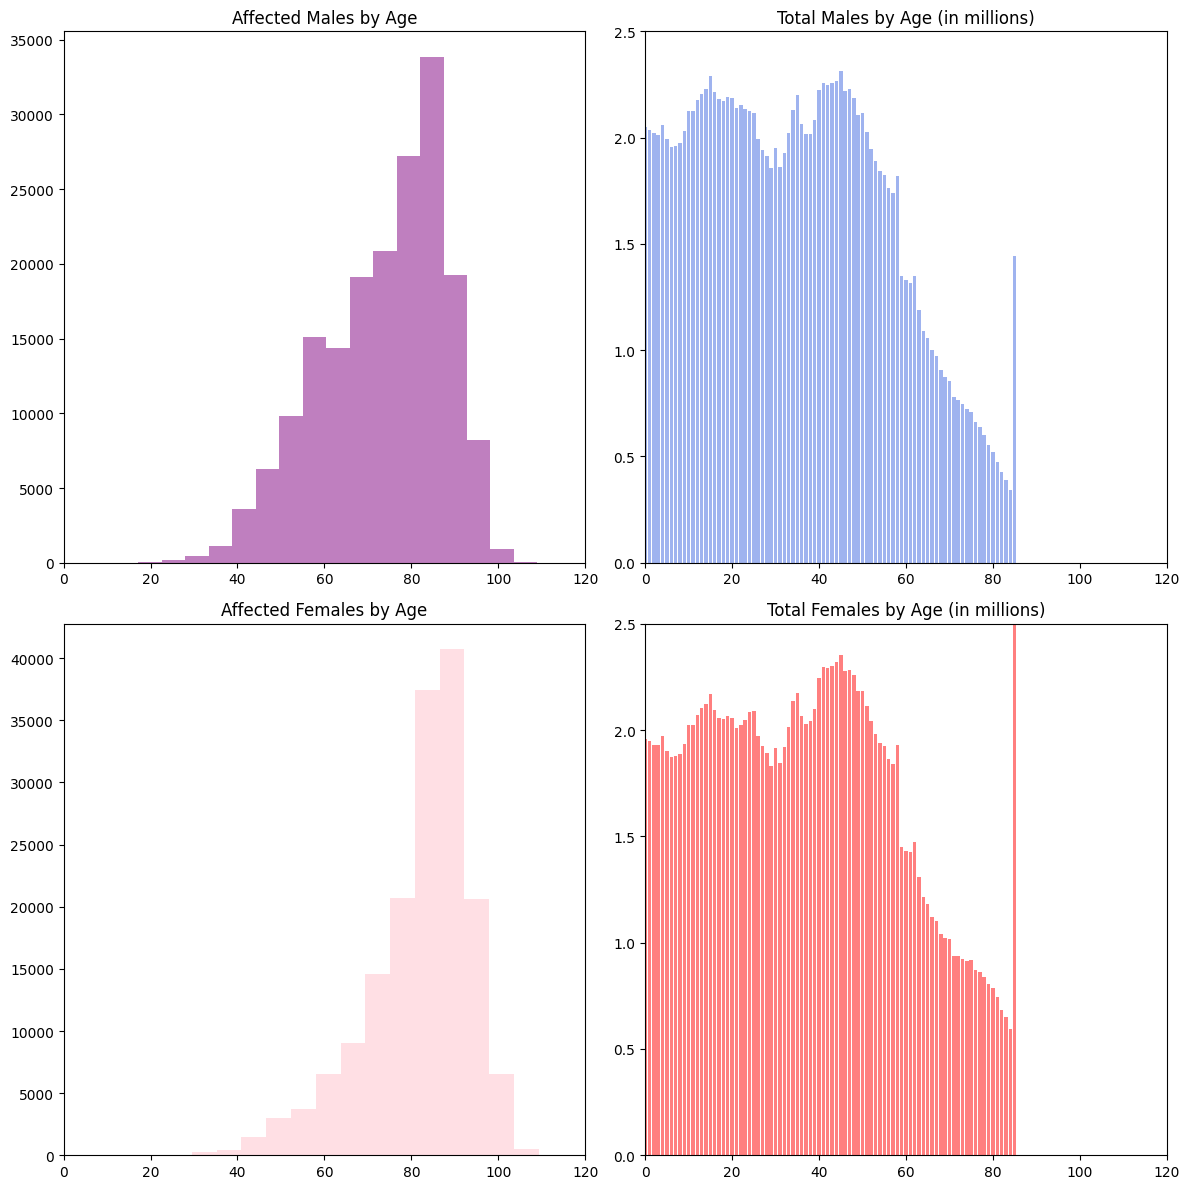

In [56]:
# Filter the heart disease dataframe for affected individuals and drop age values above 120
male_heart_disease_df = heart_disease_df[(heart_disease_df['sex_text'] == 'Male') & (heart_disease_df['detail_age'] <= 120)]
female_heart_disease_df = heart_disease_df[(heart_disease_df['sex_text'] == 'Female') & (heart_disease_df['detail_age'] <= 120)]

# Filter the population dataframe for the year 2005 and drop age values above 120
male_pop_2005_df = pop_data_2005_df[(pop_data_2005_df['SEX'] == 'Male') & (pop_data_2005_df['AGE'] <= 120)]
female_pop_2005_df = pop_data_2005_df[(pop_data_2005_df['SEX'] == 'Female') & (pop_data_2005_df['AGE'] <= 120)]

# Create subplots for male histograms side by side and female histograms below the males
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot affected males on the left
axs[0, 0].hist(male_heart_disease_df['detail_age'], bins=20, color='purple', alpha=0.5)
axs[0, 0].set_title('Affected Males by Age')
axs[0, 0].set_xlim(0, 120)

# Plot total males on the right with bar heights based on population estimates in millions
axs[0, 1].bar(male_pop_2005_df['AGE'], male_pop_2005_df['POPESTIMATE2005'] / 1000000, color='royalblue', alpha=0.5)
axs[0, 1].set_title('Total Males by Age (in millions)')
axs[0, 1].set_xlim(0, 120)
axs[0, 1].set_ylim(0, 2.5)
axs[0, 1].set_yticks(np.arange(0, 2.6, 0.5))

# Plot affected females below affected males
axs[1, 0].hist(female_heart_disease_df['detail_age'], bins=20, color='pink', alpha=0.5)
axs[1, 0].set_title('Affected Females by Age')
axs[1, 0].set_xlim(0, 120)

# Plot total females below total males with bar heights based on population estimates in millions
axs[1, 1].bar(female_pop_2005_df['AGE'], female_pop_2005_df['POPESTIMATE2005'] / 1000000, color='red', alpha=0.5)
axs[1, 1].set_title('Total Females by Age (in millions)')
axs[1, 1].set_xlim(0, 120)
axs[1, 1].set_ylim(0, 2.5)
axs[1, 1].set_yticks(np.arange(0, 2.6, 0.5))

plt.tight_layout()
plt.show()

### The right shift/skew in the population curves for males and females whose death was due to heart disease is not unexpected as contributing factors to the decrease in overall cardiac health are often cummulative over time (poor diet, sedentary lifestyle, etc). Review of the frequency calculations for the affected male and affected female populations shows both the mean and median values are less accurate measures for the age at which an individual will die from heart disease, when compared to the mode. 
### Males (Mean: 73.61, Median: 76.00, Mode: 84)
### Females (Mean: 81.89, Median: 84.00, Mode: 87): e: int64

## 2. Is there a relationship between age and dying of heart disease in the US?
---------------------------------------------------------------------------------

In [76]:
#Group the total population data into 5 year ag groups and calculate the population total for each age group

# Create a new column to represent the five-year age groups
pop_data_2005_df['Five_Year_Frame'] = (pop_data_2005_df['AGE'] // 5) * 5

# Group the data by five-year age groups and calculate the sum of "POPESTIMATE2005"
pop_result = pop_data_2005_df.groupby('Five_Year_Frame')['POPESTIMATE2005'].sum()

# Display the result showing the sum for each five-year age group
print(pop_result)

Five_Year_Frame
0     19917400
5     19389067
10    21212579
15    21486214
20    20959955
25    19534710
30    19723937
35    20798653
40    22706885
45    22417171
50    20078733
55    17503220
60    13138277
65    10278627
70     8603070
75     7463609
80     5611193
85     4693299
Name: POPESTIMATE2005, dtype: int64


In [77]:
# Group the affected popoulation data into 5-year age groups and calculate the affected population total for each age group

# Create a new column to represent the five-year age group
heart_disease_df['Five_Year_Age_Group'] = (heart_disease_df['detail_age'] // 5) * 5

# Group the data by five-year age groups and calculate the count for each group
aff_result = heart_disease_df.groupby('Five_Year_Age_Group').size()

# Display the count for each five-year age group
print(aff_result)

Five_Year_Age_Group
0         12
5          9
10        10
15        30
20       126
25       246
30       649
35      1686
40      4251
45      8092
50     12840
55     16851
60     20090
65     22762
70     30300
75     43368
80     58290
85     59556
90     44761
95     18164
100     3729
105      320
110       15
115        2
995       26
dtype: int64


In [ ]:
#Determine if a signficant difference exists between age groups for all individuals dying from heart disease

In [ ]:
# Evaluate if useful with modification later
# Extract individual groups based on gender and age group counts
# group_male = gender_counts_by_age.loc['Male']
# group_female = gender_counts_by_age.loc['Female']

# # Perform ANOVA test using the counts of males and females by age group
# from scipy.stats import f_oneway

# # Perform ANOVA test
# f_statistic, p_value = f_oneway(group_male, group_female)

# # Display the ANOVA results
# print("ANOVA Results:")
# print(f"F-Statistic: {f_statistic}")
# print(f"P-Value: {p_value}")

# # Check if the difference is statistically significant
# alpha = 0.05
# if p_value < alpha:
#     print("The difference between male and female counts by age group is statistically significant.")
# else:
#     print("The difference between male and female counts by age group is not statistically significant.")

In [78]:
#Determine rate of death by age group

# Step 3: Calculate the death rate per 1000 people for each age group
death_rate_per_1000 = (aff_result / pop_result) * 1000

# Display the death rate per 1000 people for each five-year age group
print(death_rate_per_1000)

0       0.000602
5       0.000464
10      0.000471
15      0.001396
20      0.006011
25      0.012593
30      0.032904
35      0.081063
40      0.187212
45      0.360973
50      0.639483
55      0.962737
60      1.529120
65      2.214498
70      3.521999
75      5.810594
80     10.388165
85     12.689581
90           NaN
95           NaN
100          NaN
105          NaN
110          NaN
115          NaN
995          NaN
dtype: float64


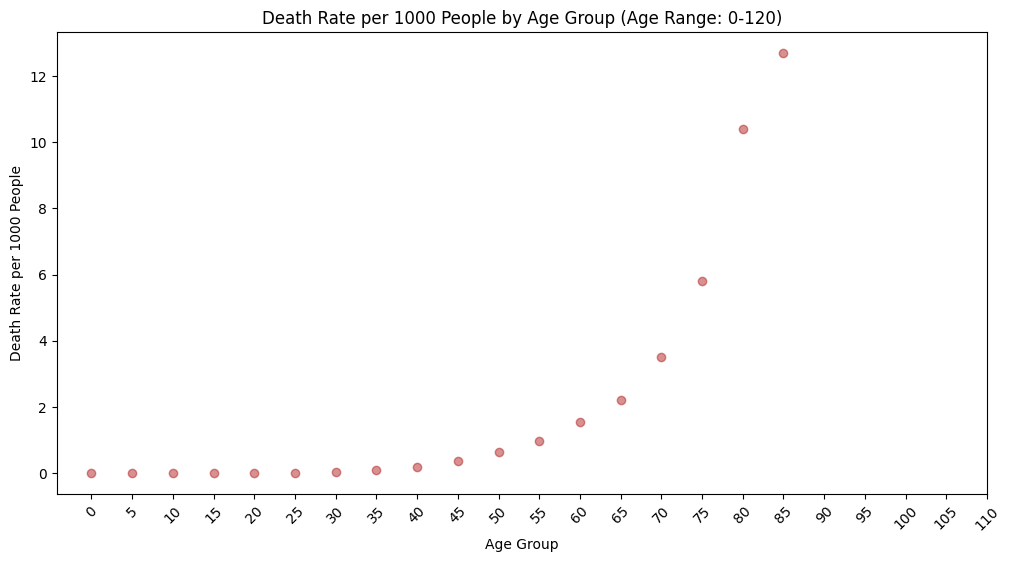

In [105]:
# Create a scatter plot of the rate of death (per 1000 people in total population) due to heart disease

# Define data points every 5 years to provide more data points for plotting
filtered_df["age_group"] = ((filtered_df["detail_age"] - 1) // 5) * 5

# Group by age group and calculate the death rate per 1000 people in each group
death_rate_per_1000 = death_rate_per_1000.reindex(filtered_df["age_group"].unique())  # Match death rates to age groups

# Create a scatter plot of death rate per 1000 people by age group
plt.figure(figsize=(12, 6))
plt.scatter(death_rate_per_1000.index, death_rate_per_1000, color="firebrick", alpha=0.5)
plt.title("Death Rate per 1000 People by Age Group (Age Range: 0-120)")
plt.xlabel("Age Group")
plt.ylabel("Death Rate per 1000 People")
plt.xticks(death_rate_per_1000.index, rotation=45)
plt.show()

Regression Equation: y = nanx + nan
R-squared value: nan


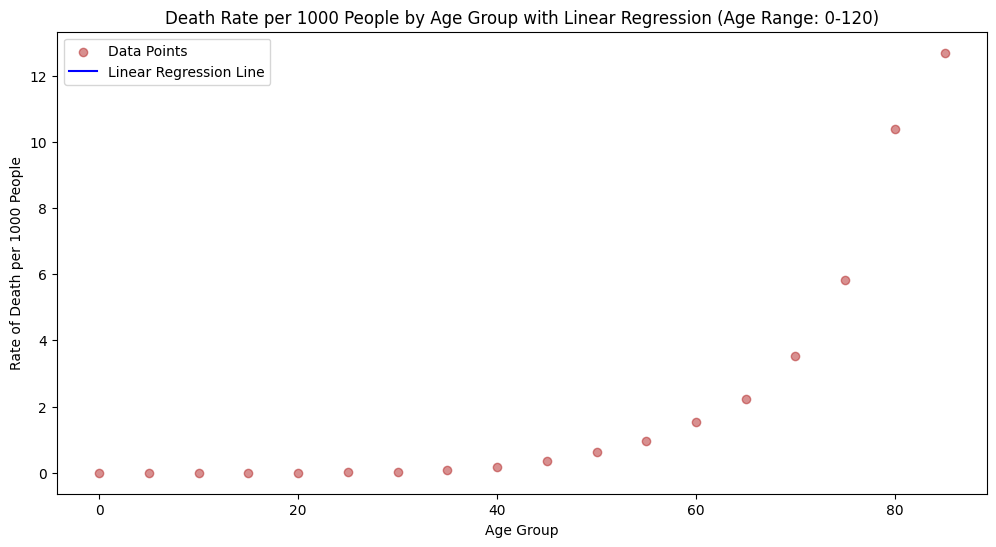

In [106]:
#Determine if there is a relationship between age and rate of death due to heart disease using linear regression analysis

# Define x and y values for the linear regression analysis
x_values = death_rate_per_1000.index
y_values = death_rate_per_1000.values

# Perform linear regression analysis
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)

# Calculate the regression line
regression_line = slope * x_values + intercept
print(f"Regression Equation: y = {slope:.2f}x + {intercept:.2f}")

# Calculate R-squared value
r_squared = r_value ** 2
print(f"R-squared value: {r_squared}")

# Create a scatter plot with the linear regression line
plt.figure(figsize=(12, 6))
plt.scatter(x_values, y_values, color="firebrick", alpha=0.5, label='Data Points')
plt.plot(x_values, regression_line, color='blue', label='Linear Regression Line')
plt.title("Death Rate per 1000 People by Age Group with Linear Regression (Age Range: 0-120)")
plt.xlabel("Age Group")
plt.ylabel("Rate of Death per 1000 People")
plt.legend()
plt.show()

# --------------------------------------------------------------------------------
# Check cells below. Need to verify edits reflect death rate and not total deaths. Cells above confirmed correct.
# --------------------------------------------------------------------------------

R-squared value: 0.21592095183996315


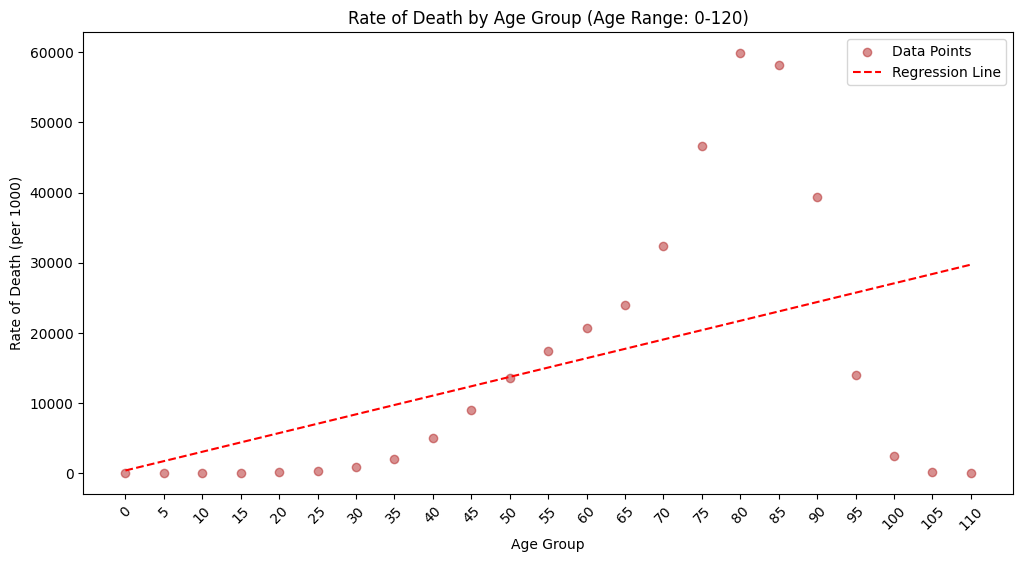

In [103]:
#Determine if there is a relationship between age and death due to heart disease using linear regression analysis

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(age_group_counts.index, age_group_counts)
regression_line = slope * age_group_counts.index + intercept

# Calculate R-squared value
r_squared = r_value ** 2
print(f"R-squared value: {r_squared}")

# Create a scatter plot of deaths by age group
plt.figure(figsize=(12, 6))
plt.scatter(age_group_counts.index, age_group_counts, color='firebrick', alpha=0.5, label='Data Points')
plt.plot(age_group_counts.index, regression_line, color='red', linestyle='--', label='Regression Line')
plt.title('Rate of Death by Age Group (Age Range: 0-120)')
plt.xlabel('Age Group')
plt.ylabel('Rate of Death per 1000 People')
plt.xticks(age_group_counts.index, rotation=45)
plt.legend()
plt.show()

### Enter discussion of the R^2 value and what it means (or doesn't)

In [92]:
#Determine if there is a relationship between age and rate of death due to heart disease using curvilinear regression analysis

# Define the curve function for curve fitting
def death_rate_curve(age, a, b, c):
    y_increase = a * np.exp(b * age) + c
    return y_increase

# Define x and y values for curve fitting
x_values = death_rate_per_1000.index
y_values = death_rate_per_1000.values

# # Remove any rows with NaN or infinite values
# valid_indices = np.isfinite(x_values) & np.isfinite(y_values)
# x_values_clean = x_values[valid_indices]
# y_values_clean = y_values[valid_indices]

# Perform curve fitting using the cleaned data
popt, pcov = curve_fit(death_rate_curve, x_values, y_values)
# popt, pcov = curve_fit(death_rate_curve, x_values_clean, y_values_clean)

# # Generate the fitted curve using the optimized parameters
# fitted_curve = curve_function(x_values_clean, *popt)

# # Print the optimized parameters
# print("Optimized Parameters (a, b, c):", popt)

# # Create a plot to visualize the original data and the fitted curve
# plt.figure(figsize=(12, 6))
# plt.scatter(x_values_clean, y_values_clean, color="firebrick", alpha=0.5, label='Data Points')
# plt.plot(x_values_clean, fitted_curve, color='blue', label='Fitted Curve')
# plt.title("Death Rate per 1000 People by Age Group (Exponential Curve Fitting)")
# plt.xlabel("Age Group")
# plt.ylabel("Death Rate per 1000 People")
# plt.legend()
# plt.xticks(x_values_clean, rotation=45)
# plt.show()

ValueError: array must not contain infs or NaNs

In [100]:
# Define an exponential function for curve fitting betwen ages 0 and 80
def inc_exponential_death(age, a, b, c):
    y_increase = a * np.exp(b * (age-PEAK_AGE)) + c
    return y_increase 

In [101]:
#Define separate populations (increasing curve up to age 80, decreasing curve afterwards)
age_group_counts_leq_peak = age_group_counts[age_group_counts.index <= PEAK_AGE]
#age_group_counts_geq_peak = age_group_counts[age_group_counts.index >= PEAK_AGE]

In [102]:
Determine if there is a relationship between age and death due to heart disease using curvilinear regression analysis up to age 80

# Perform curvilinear regression (AKA curve fitting) 
popt, pcov = curve_fit(inc_exponential_death, age_group_counts_leq_peak.index, age_group_counts_leq_peak.values)

#Calculate the R-squared value
y_pred_leq = inc_exponential_death(age_group_counts_leq_peak.index, *popt)
r_squared = r2_score(age_group_counts_leq_peak.index, y_pred_leq)
print(f"The R-squared value is: {r_squared}")

# Create a scatter plot of deaths by age group
plt.figure(figsize=(12, 6))
plt.scatter(age_group_counts_leq_peak.index, age_group_counts_leq_peak, color='firebrick', alpha=0.5, label='Data Points')
plt.plot(age_group_counts_leq_peak.index, inc_exponential_death(age_group_counts_leq_peak.index, *popt), color='red', linestyle='--', label='Fitted Curve')
plt.title('Number of Deaths by Age Group (Age Range: 0-80)')
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths')
plt.xticks(age_group_counts_leq_peak.index, rotation=45)
plt.legend()
plt.annotate(popt, (0, 100000), color='red')
plt.show()

SyntaxError: expected 'else' after 'if' expression (4121259083.py, line 1)

In [93]:
# Define an exponential function for curve fitting betwen ages 0 and 80
def dec_exponential_death(age, d, f, g):
    y_decrease = d * np.exp(f * (PEAK_AGE-age)) + g
    return y_decrease 

In [94]:
#Define separate populations (increasing curve up to age 80, decreasing curve afterwards)
age_group_counts_geq_peak = age_group_counts[age_group_counts.index >= PEAK_AGE]

The R-squared value is: -11965841.711591134


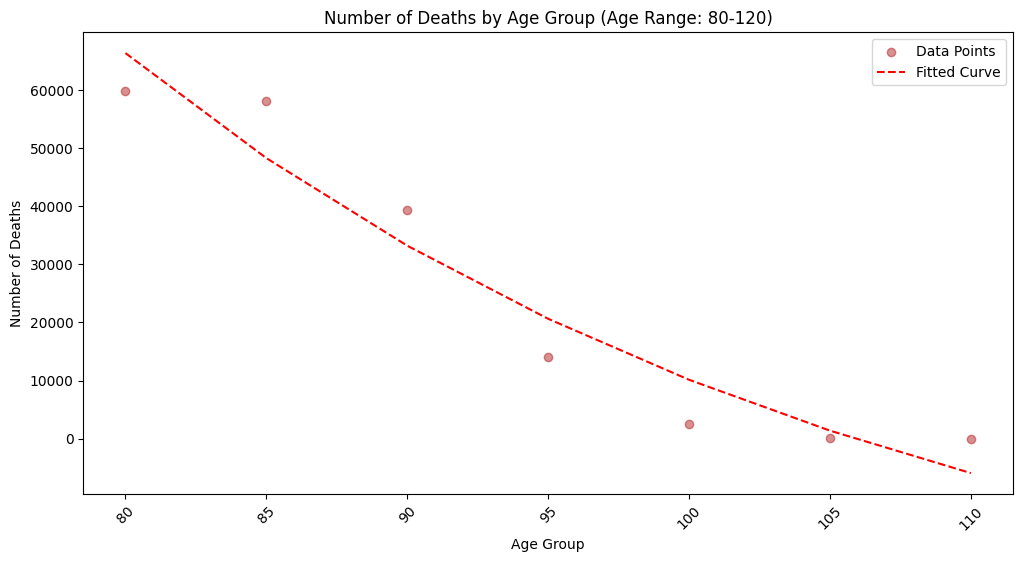

In [95]:
#Determine if there is a relationship between age and death due to heart disease using curvilinear regression analysis up to age 80

# Perform curvilinear regression (AKA curve fitting) 
popt, pcov = curve_fit(dec_exponential_death, age_group_counts_geq_peak.index, age_group_counts_geq_peak.values)

#Calculate the R-squared value
y_pred_geq = dec_exponential_death(age_group_counts_geq_peak.index, *popt)
r_squared = r2_score(age_group_counts_geq_peak.index, y_pred_geq)
print(f"The R-squared value is: {r_squared}")

# Create a scatter plot of deaths by age group
plt.figure(figsize=(12, 6))
plt.scatter(age_group_counts_geq_peak.index, age_group_counts_geq_peak, color='firebrick', alpha=0.5, label='Data Points')
plt.plot(age_group_counts_geq_peak.index, dec_exponential_death(age_group_counts_geq_peak.index, *popt), color='red', linestyle='--', label='Fitted Curve')
plt.title('Number of Deaths by Age Group (Age Range: 80-120)')
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths')
plt.xticks(age_group_counts_geq_peak.index, rotation=45)
plt.legend()
plt.annotate(popt, (0, 100000), color='red')
plt.show()

In [96]:
#Describe the relationship

In [97]:
#Evaluate differences in the trend in males vs females between 0-80 and 80-120

# Filter the data for Males and age between 0 and 80
male_heart_data = heart_disease_df[(heart_disease_df['sex_text'] == 'Male') & (heart_disease_df['detail_age'] >= 0) & (heart_disease_df['detail_age'] <= 80)]
female_heart_data = heart_disease_df[(heart_disease_df['sex_text'] == 'Female') & (heart_disease_df['detail_age'] >= 0) & (heart_disease_df['detail_age'] <= 80)]




### Use this cell to describe findings about age and death rate due to heart disease

## 3. Is there a relationship between race and deaths due to heart disease in the US?

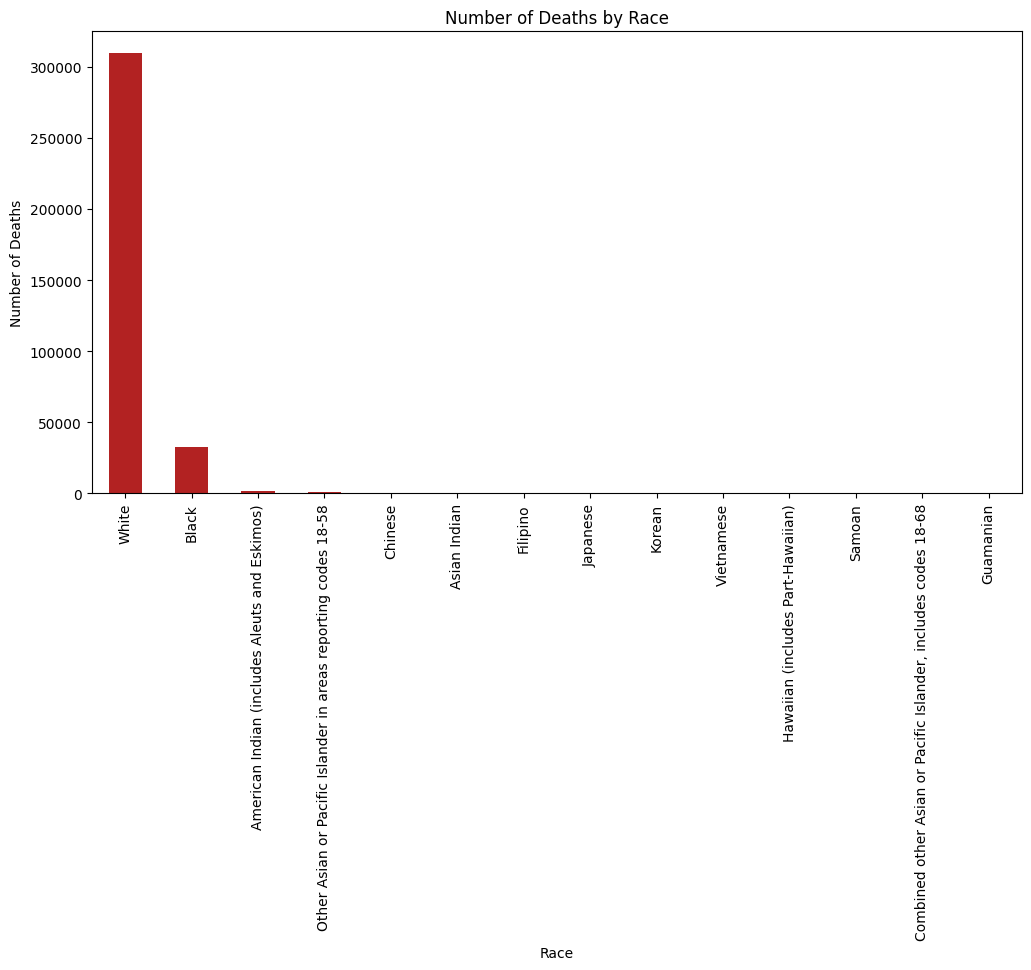

In [99]:
# Create a histogram of deaths due to heart disease by race

plt.figure(figsize=(12, 6))
heart_disease_df['race_text'].value_counts().plot(kind='bar', color='firebrick')
plt.title('Number of Deaths by Race')
plt.xlabel('Race')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=90)
plt.show()

### The majority of deaths due to heart disease in this dataset occurred in the Caucasian population. While there is some representation for African American individuals dying from heart diease, the remaining races are not sufficient in number to identify any additional patterns due to race. 

### To better determine if race and heart disease have a relationship, the data will be evaluated by cause of death per race, rather than race per cause of death, to show a more meaningful realtionship between the percentages of each race that are affected by heart disease and other causes of death. Refer to additional notebook: TITLE

## 4. Is there a relationship between location and death due to heart disease in the US?

In [ ]:
#Where do individuals with heart diease die?

In [ ]:
#Are there differences between location for male vs female?

In [ ]:
#Are there differences between location by age group?

In [ ]:
#Describe any relationships statistically
#use ANOVA

## 5. Is there a relationship between the manner of death and heart disease in the US?

In [ ]:
#What is the nature of the individuals dying from heart disease (natural vs suicide vs homicide, etc)

In [ ]:
#Are there any differences by sex?

In [ ]:
#Are there any differences by age group?

In [ ]:
#Describe any relationships statistically
#use ANOVA